![Py4Eng](img/logo.png)

# Linear Model
## Yoav Ram

In [1]:
import urllib.request
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

# import warnings
# warnings.simplefilter('ignore', FutureWarning)
# warnings.simplefilter('ignore', UserWarning)

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)
pd.set_option('display.max_columns', 10000)

# Get the data

We will use some tennis data so that we can talk about *linear regression*.

We start by openning the zip file and print its contents.

Note 1: [`zipfile`](https://docs.python.org/3/library/zipfile.html) is part of Python standard library, which also includes modules for [`gzip`](https://docs.python.org/3/library/gzip.html), [`bz2`](https://docs.python.org/3/library/bz2.html) and other compression formats.
Note 2: Data from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.

In [2]:
filename = '../data/tennis.zip'
tennis_zip = zipfile.ZipFile(filename)
for f in tennis_zip.filelist: 
    print(f.filename)

data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


So we have CSV files for Tennis' [Big Four](https://en.wikipedia.org/wiki/Big_Four_%28tennis%29).

We can open CSV files with the standard library's [`csv`](https://docs.python.org/3/library/csv.html) module, but it is much more convinient to use Pandas.

In [3]:
player = 'Novak Djokovic'
path = 'data/{}.csv'
path = path.format(player.replace(' ', '-'))
with tennis_zip.open(path) as f:
    df = pd.read_csv(f)
df = df.dropna()
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,opponent,ranking,score,stats link,tournament.1,tournament round,time,winner,player1 name,player1 nationality,player1 aces,player1 double faults,player1 1st serves in,player1 1st serves total,player1 1st serve points won,player1 1st serve points total,player1 2nd serve points won,player1 2nd serve points total,player1 break points won,player1 break points total,player1 service games played,player1 1st serve return points won,player1 1st serve return points total,player1 2nd serve return points won,player1 2nd serve return points total,player1 break points converted won,player1 break points converted total,player1 return games played,player1 total service points won,player1 total service points total,player1 total return points won,player1 total return points total,player1 total points won,player1 total points total,player2 name,player2 nationality,player2 aces,player2 double faults,player2 1st serves in,player2 1st serves total,player2 1st serve points won,player2 1st serve points total,player2 2nd serve points won,player2 2nd serve points total,player2 break points won,player2 break points total,player2 service games played,player2 1st serve return points won,player2 1st serve return points total,player2 2nd serve return points won,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
25,2004,"Bangkok, Thailand",27.09.2004,WS,Indoor: Hard,Draw: 32,5,248.0,"$5,385",R32,Dennis van Scheppingen (NED),81,"L 6-4, 5-7, 4-6",http://www.atpworldtour.com/Share/Match-Facts-...,Bangkok,R32,112,Dennis van Scheppingen,Novak Djokovic,Serbia,15.0,12.0,70.0,118.0,45.0,70.0,22.0,48.0,10.0,15.0,16.0,18.0,57.0,13.0,31.0,4.0,7.0,16.0,67.0,118.0,31.0,88.0,98.0,206.0,Dennis van Scheppingen,Netherlands,7.0,7.0,57.0,88.0,39.0,57.0,18.0,31.0,3.0,7.0,16.0,25.0,70.0,26.0,48.0,5.0,15.0,16.0,57.0,88.0,51.0,118.0,108.0,206.0
26,2004,"Bucharest, Romania",13.09.2004,WS,Outdoor: Clay,Draw: 32,20,272.0,"$6,225",R32,Arnaud Clement (FRA),67,"W 2-6, 6-4, 6-4",http://www.atpworldtour.com/Share/Match-Facts-...,Bucharest,R32,146,Novak Djokovic,Novak Djokovic,Serbia,4.0,2.0,60.0,91.0,39.0,60.0,19.0,31.0,2.0,5.0,14.0,22.0,62.0,15.0,31.0,3.0,10.0,14.0,58.0,91.0,37.0,93.0,95.0,184.0,Arnaud Clement,France,0.0,2.0,62.0,93.0,40.0,62.0,16.0,31.0,7.0,10.0,14.0,21.0,60.0,12.0,31.0,3.0,5.0,14.0,56.0,93.0,33.0,91.0,89.0,184.0
27,2004,"Bucharest, Romania",13.09.2004,WS,Outdoor: Clay,Draw: 32,20,272.0,"$6,225",R16,David Ferrer (ESP),54,"L 6-4, 4-6, 4-6",http://www.atpworldtour.com/Share/Match-Facts-...,Bucharest,R16,155,David Ferrer,Novak Djokovic,Serbia,3.0,1.0,62.0,98.0,37.0,62.0,14.0,36.0,5.0,11.0,15.0,27.0,61.0,21.0,46.0,5.0,19.0,15.0,51.0,98.0,48.0,107.0,99.0,205.0,David Ferrer,Spain,1.0,2.0,61.0,107.0,34.0,61.0,25.0,46.0,14.0,19.0,15.0,25.0,62.0,22.0,36.0,6.0,11.0,15.0,59.0,107.0,47.0,98.0,106.0,205.0
39,2004,"Umag, Croatia",19.07.2004,WS,Outdoor: Clay,Draw: 32,10,368.0,"$3,900",R32,Filippo Volandri (ITA),65,"L 6-7(5), 1-6",http://www.atpworldtour.com/Share/Match-Facts-...,Umag,R32,90,Filippo Volandri,Novak Djokovic,Serbia,4.0,6.0,40.0,65.0,20.0,40.0,6.0,25.0,2.0,8.0,9.0,17.0,39.0,17.0,35.0,4.0,10.0,10.0,26.0,65.0,34.0,74.0,60.0,139.0,Filippo Volandri,Italy,0.0,7.0,39.0,74.0,22.0,39.0,18.0,35.0,6.0,10.0,10.0,20.0,40.0,19.0,25.0,6.0,8.0,9.0,40.0,74.0,39.0,65.0,79.0,139.0
62,2005,"ATP Masters Series Paris, France",31.10.2005,SU,Indoor: Carpet,Draw: 48,90,85.0,"$28,430",R64,Victor Hanescu (ROU),37,W 4-1 RET,http://www.atpworldtour.com/Share/Match-Facts-...,ATP Masters Series Paris,R64,19,Novak Djokovic,Novak Djokovic,Serbia,1.0,1.0,8.0,12.0,6.0,8.0,2.0,4.0,0.0,0.0,2.0,4.0,12.0,7.0,8.0,2.0,5.0,3.0,8.0,12.0,11.0,20.0,1

## Exercise: plotting

Plotting is done by calling functions from the `plot` attribute of the dataframe, but the underlying mechanism is at work is *matplotlib*, the fundamental Python plotting library.

Now let's plot the points won vs points aced to try and see if one can explain the other.

Bonus points: `marker` and `alpha` keyword arguments control the marker shape and the transparency, use these arguments to plot with `.` instead of the default `o` and with tranparancy of 3/4.

**Reminder**
- Edit cell by double clicking
- Run cell by pressing _Shift+Enter_
- Get autocompletion by pressing _Tab_
- Get documentation by pressing _Shift+Tab_

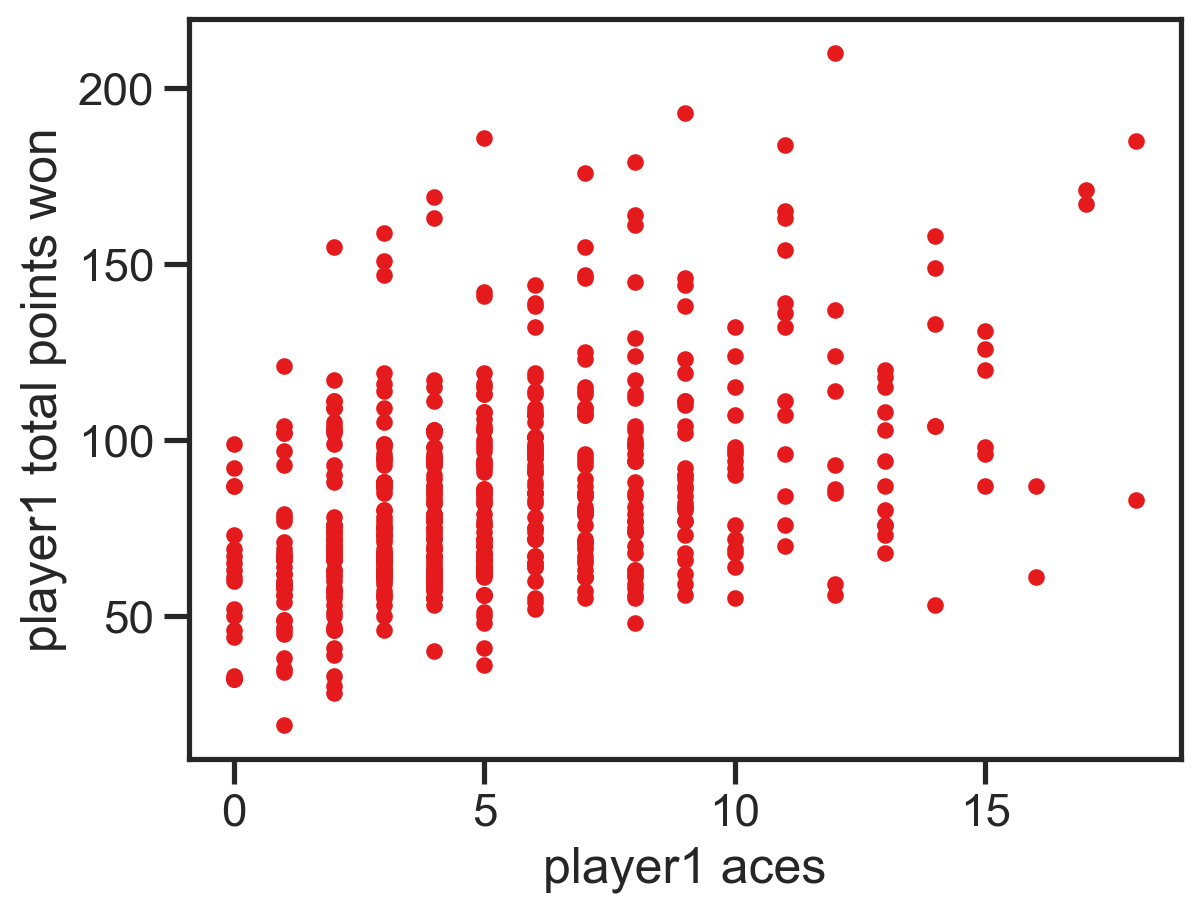

# Linear model

Can the number of aces by Novak provide a good predictor of the number of points he won?

The simplest model for such predictions is the linear model
$$
\widehat{y} = ax + b
$$
where here $x$ is the aces and $y$ is the points won.
The model parameters can be interpreted as follows:
- the intercept $b$ is the estimate for points won if 0 points were aced, $b = \widehat{y}(x=0)$, and
- the slope $a$ is the estimate for the linear increase in points won for every additional ace, $a = \widehat{y}(x+1)-\widehat{y}(x)$.

How do we find suitable $a$ and $b$?
For a given $a$ and $b$, we mark the real points won as $y$ and calculate the distance between the predictions and the observed values.
We plot a histogram of these differences, called [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals).
Here, `bins` controls the number (if `int`) or locations (if `list`) of the histogram bins.

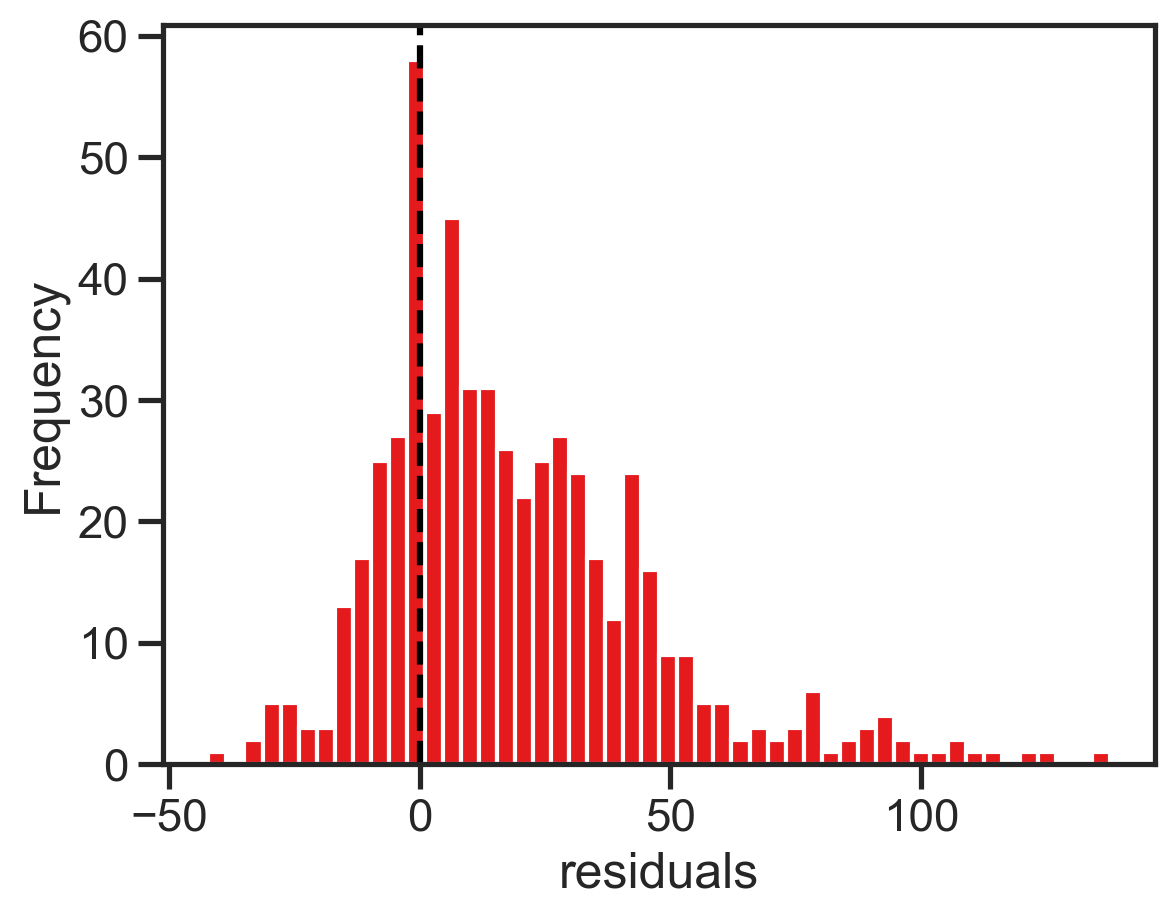

In [4]:
X = df['player1 aces']
Y = df['player1 total points won']

a = 1
b = (Y[X==0]).mean()

Yhat = a * X + b
residuals = Y - Yhat

residuals.plot.hist(bins=50)
plt.axvline(x=0, color='k', ls='--')
plt.xlabel('residuals');

We can see that the distribution is not really gaussian/normal, we'll get back to that later.

# Maximum likelihood & least squares

In the simplest form of linear modeling, we assume that the residuals (the distance between our prediction and the observed values) has a [normal (or Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution). 
However, this assumption is not a must, and the framework of [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) allow us to replace the normal distribution with other distributions such as the binomial distribution (which might be more suitable in this case, in which y values are integers).
We'll talk about it again later.

Usually, when we speak about probabilities, we ask *"what is the probability to see this data given this model"* - when I say "model" I mean something like $y=ax+b$ with given values for $a$ and $b$, such as $a=1$ and $b=0$, and a normal distribution of errors, that is, that observed values should be normally distributed around the expected value:
$$
y \sim Normal\big(\widehat{y}, \sigma^2\big)
$$
where $\sigma^2$ is the variance of the distribution.

That is, we want to say something about expected data given a model.
The probability for an observation $y$ is
$$
P(y) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(y - \widehat{y})^2}{2\sigma^2}\bigg).
$$

But in cases where we have data and we try to say something about the expected model given observed data.
This is where *likelihood* comes into place, and its definition is straight-forward:
The **likelihood of the model** $y \sim Normal(ax+b, \sigma^2)$ given observed data $(x, y)$ is the probability of seeing data $(x,y)$ given the model $y \sim Normal(ax+b, \sigma^2)$.

If we have mutliple data points (we do!) we just multiply all of them under the assumption that each data point (here, game point, so.. confusing) is *independent* (in the probability sense of independence, that is, knowing what happened in one of them doesn't change the probability of the other one occuring).

So the likelihood of the model $y \sim Normal(ax+b, \sigma^2)$ given data points $(x_i, y_i)$, where $i$ indexes the point, is
$$
\mathbf{L}(a,b | x_i, y_i) = \frac{1}{(2 \pi \sigma^2)^{n/2}} \prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i - ax_i -b)^2}{2\sigma^2}\bigg)}
$$

After establishing what likelihood is, we can ask _what are the parameters $a$ and $b$ that maximize the model likelihood?_. 

This is akin to asking what are $a$ and $b$ for which the probability of seeing the data we saw is maximized.
This approach is called **maximum likelihood**.

Now, our likelihood $\mathbf{L}$ is a product of exponents, so we can take the log-likelihood (literally the log of the likelihood) to get a simpler expression
$$
\log\mathbf{L} = \\
\log (2 \pi \sigma^2)^{-n/2} + \log{\prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i - ax_i -b)^2}{2\sigma^2}\bigg)}} = $$$$
-\frac{n}{2}\log{(2 \pi \sigma^2)} + \sum_{i=1}^{n}{-\frac{(y_i-ax_i-b)^2}{2\sigma^2}} = $$$$
-\frac{n}{2}\log{(2 \pi \sigma^2)} - \frac{1}{2\sigma^2} \sum_{i=1}^{n}{(y_i-ax_i-b)^2}
$$

Note that 
- $\log{\mathbf{L}}$ is an increasing function of $\mathbf{L}$ so maximizing the log-likelihood is equivalent to maximizing the likelihood
- $a$ and $b$ only appear in the sum-of-squares, which is prepended by a negative sign, so minimizing the sum-of-squares is equivalent to maximizing the log-likelihood
- if we only care about the best estimate of $a$ and $b$ then we don't really care about the variance $\sigma^2$ (we would care if we wanted to have some statistical measure of precision or confidence)

This is where the **least squares** approach comes from: when assuming a model with normal distribution of residuals, maximizing the likelihood is equivalent to minimizing the sum-of-squares of the residials, or the deviances between the model prediction $\widehat{y}$ and the observed value $y$.

Note that this works with non-linear models just the same, as long as the residuals are normally and independently distributed.

In ths case of a linear model there is a formula to find $a$ and $\sigma^2$ when $b=0$, but since we will later deal with cases in which there is no formula, let's continue as if there is no formula.

Let's calculate the sum-of-squares. 
Note that Pandas aggregation methods (such as `sum` or `mean`) ignore NaN values, but this is not always the case in other numerical packages.

In [5]:
(residuals**2).sum()

608415.0886426591

## Exercise: sumsquares

Write a function that calculates the sum-of-squares for some $a$ and $b$ values and the data $x,y$:

In [6]:
def sumsquares(a, b, X, Y):
    # your code here

In [7]:
sumsquares(a, b, X, Y)

608415.0886426591

Now we would like to find $a$ and $b$ that minimize the function `sumsquares`.

# Gradient descent

One way to do this is with *gradient descent*.
This is an iterative algorithm.
In each step, we calculate that gradient of the function (sum-squares) with respect to model parameters $a$ and $b$ (the gradient is just the vector of derivatives):
$$
RSS \big(a, b, x, y\big) = \sum_{i=1}^{n}{(y_i-ax_i-b)^2} $$$$
\frac{\partial RSS}{\partial a} = \sum_{i=1}^{n}{2ax^2 +2bx -2xy} $$$$
\frac{\partial RSS}{\partial b} = \sum_{i=1}^{n}{2ax +2b -2y}
$$
and "descend" (minimize) the function just a tiny bit by updating $a$ and $b$ in the oppositve direction of the gradient:
$$
a_t = a_{t-1} - \eta \frac{\partial RSS}{\partial a} $$$$
b_t = b_{t-1} - \eta \frac{\partial RSS}{\partial b}
$$
where $\eta$ is the size of the step we take (the "tiny bit"), also sometimes called the *learning rate*. We'll talk later about methods in which this rate can be learned or adjusted over time.

Let's try it!


In [8]:
def gradient_descent(a, b, X, Y, η):
    dRSSda = (2*a*X*X + 2*b*X -2*X*Y).sum()
    dRSSdb = (2*a*X + 2*b - 2*Y).sum()
    return a - η * dRSSda, b - η * dRSSdb

The last technical details is the stopping condition.
We'll set the gradient descent to stop after 5000 iterations (we can run more afterwards if we want by setting `a` and `b` to start where we left off).

In [9]:
history = []
def linear_model(X, Y, a=0, b=0, η=0.00001, iters=5000, PRINT=True):  
    for t in range(iters+1):
        a, b = gradient_descent(a, b, X, Y, η)
        rss = sumsquares(a, b, X, Y)
        history.append([a, b, rss])
        if t % 500 == 0 and PRINT:            
            print("{:4d}: RSS={:.4f}, a={:.4f}, b={:.4f}".format(t, rss, a, b))
    return a, b

In [10]:
%%time
a, b = linear_model(X, Y, PRINT=False)

CPU times: user 4.93 s, sys: 39.7 ms, total: 4.97 s
Wall time: 4.95 s


## Plot the descent

We can also plot the descent trajectory.

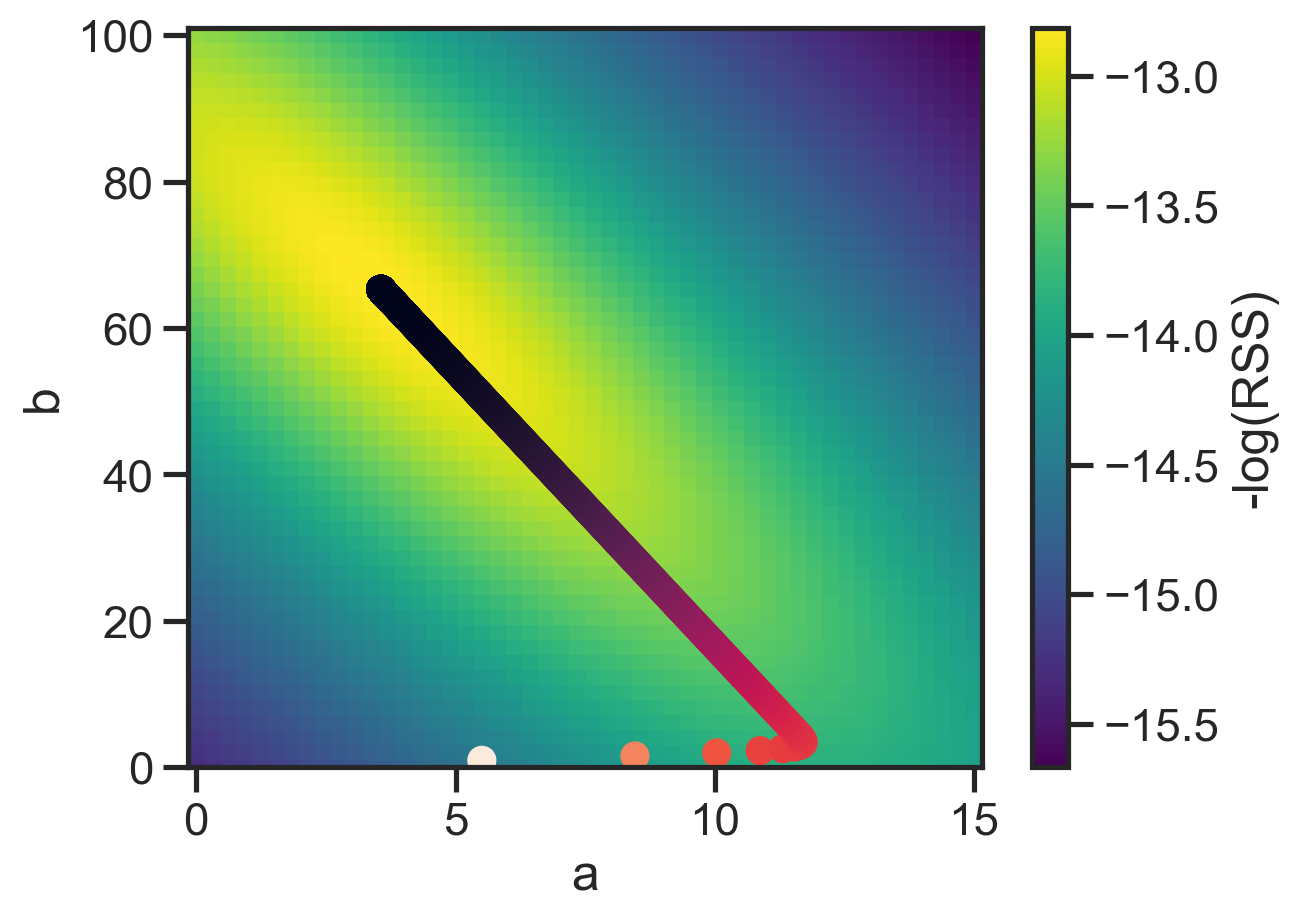

In [11]:
# some broadasting tricks to quickly compute RSS over a range of a and b values
aa, bb = np.meshgrid(np.linspace(0, 15), np.linspace(0, 100))
Yhat = (np.expand_dims(aa, 2) * X.values.reshape(1, 1, -1) + np.expand_dims(bb, 2))
rss = np.nansum((Yhat - Y.values.reshape(1,1,-1))**2, axis=2)
# end broadcasting tricks

history_arr = np.array(history)
plt.pcolormesh(aa, bb, -np.log(rss), cmap='viridis')
plt.colorbar(label='-log(RSS)')
plt.scatter(history_arr[:,0], history_arr[:,1], c=np.log(history_arr[:,2]))
plt.xlabel('a')
plt.ylim(0, None)
plt.ylabel('b');

# Plot and interpret a linear model

Let's plot the results.
We now load the [matplotlib](http://matplotlib.org) library to use it to plot a straight line over the scatterplot. Note that we sort the x values first otherwise the straight line will zigzag over the plot.

a=3.5612318279931086, b=65.30294377554792


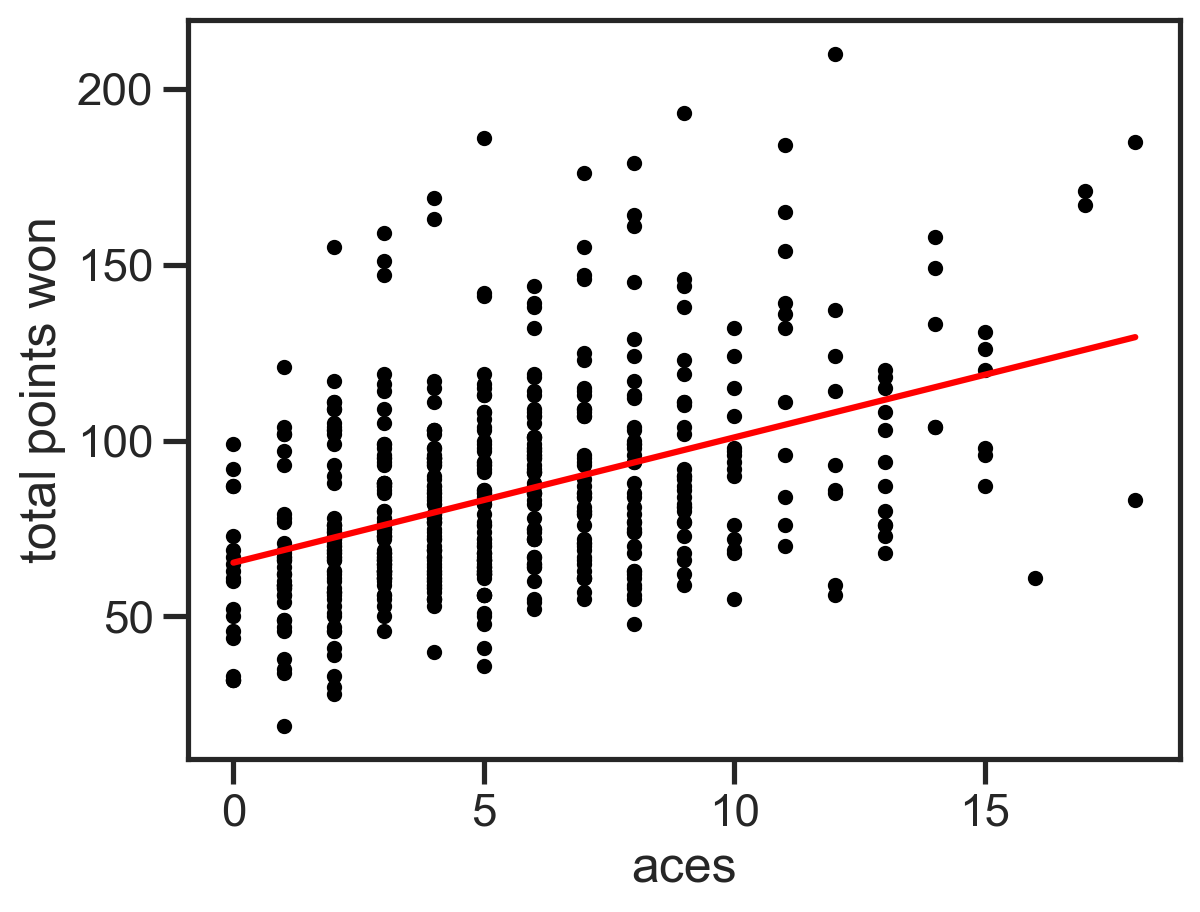

In [12]:
def plot_linear_model(a, b, X, Y, **plot_kws):
    plt.plot(X, Y, '.k',)
    X_ = X.sort_values()
    plt.plot(X_, a * X_ + b, '-r', **plot_kws)
    plt.xlabel('aces')
    plt.ylabel('total points won')
    print("a={}, b={}".format(a, b))
    
plot_linear_model(a, b, X, Y);

The results can be interpreted as follows
- without any aces, Novak wins ~65 points. 
- for any additional ace, he wins an additional ~3.5 point (more than the one point given by the ace)

This model will probably do a good job at *interpolation*, that is estimating $\widehat{y}$ for $x$ values that are within the original $x$ values, but not at *extrapolation*.
For example, if Novak aces all the points in a game, he can't wint 3.5 times the points he aced!

# Off-the-shelf solutions

Let's see how we could have done this with Python's packages instead of reinventing the wheel.

We'll work with NumPy and SciPy, the numerical and scientific backbone of scientific Python.

First, let's grab the NumPy arrays.

In [13]:
X = X.values
Y = Y.values

## NumPy

First method is NumPy's `polyfit` which fits a polynomial of specified degree to the data; in this case we want degree one. It returns the coefficients of the polynomial, which we could feed to `np.poly1d` to create a callable polynomial object.

In [14]:
a_np, b_np = np.polyfit(X, Y, 1)
print(a_np, b_np)

3.561227 65.30293


Note how much faster NumPy does it.
This is because the NumPy implementation does not use gradient descent but rather linear algebra operations.

In [15]:
%timeit linear_model(X, Y, PRINT=False)
%timeit np.polyfit(X, Y, 1)

142 ms ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.7 µs ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## SciPy
Next is SciPy's statistics package with its linear regression method, which basically uses the same method `polyfit` does (i.e. exact same result) but then also calculates some statistics.

In [16]:
res = scipy.stats.linregress(X, Y)
print(res.slope, res.intercept)

3.561230791388253 65.3029516124105


The P-value gives the probability to get this data if the null hypothesis is right; in this case, the null hypothesis is $a=0$.

The r-value is the [coefficient of correlation](https://en.wikipedia.org/wiki/Correlation_coefficient).

In [17]:
print('r={:.2f}, P={:.2g}'.format(res.rvalue, res.pvalue))

r=0.43, P=1.8e-26


# Statsmodels

This package focuses on statistical modeling, and as such, provides a full statistical analysis of the linear model.

Note that here `Y` comes before `X`.

In [51]:
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [52]:
X_ = sm.add_constant(X) # for intercept
results = sm.OLS(Y, X_).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     126.1
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           1.75e-26
Time:                        08:29:51   Log-Likelihood:                -2581.7
No. Observations:                 553   AIC:                             5167.
Df Residuals:                     551   BIC:                             5176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.3030      2.032     32.142      0.000      61.312      69.294
x1             3.5612      0.317     11.227      0.000       2.938       4.184
==============================================================================
Omnibus:                       91.913   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.471
Skew:                           1.010   Prob(JB):                     1.74e-34
Kurtosis:                       4.632   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can use Statsmodels to plot the results:

a=3.56123079138826, b=65.30295161241048


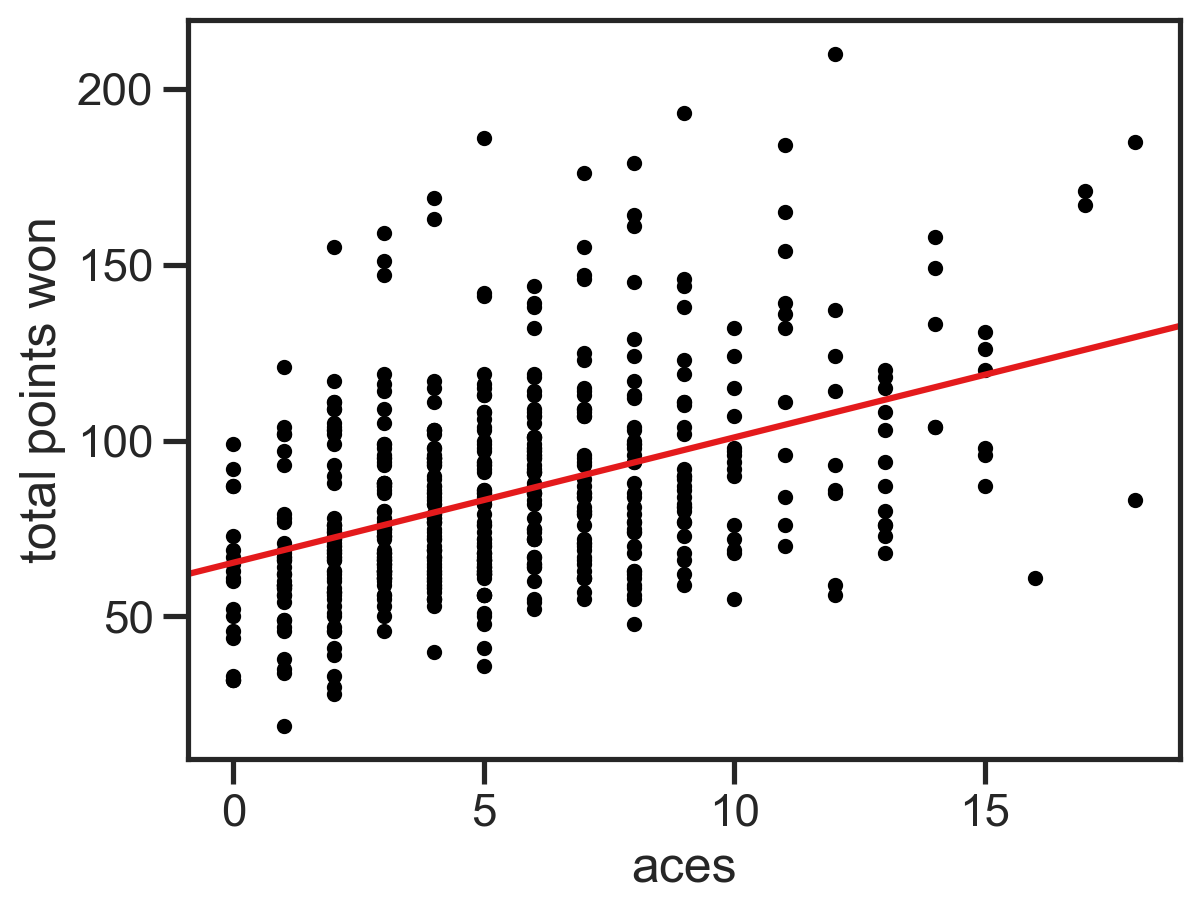

In [53]:
fig, ax = plt.subplots()
ax.plot(X, Y, '.k',)
sm.graphics.abline_plot(model_results=results, ax=ax)
ax.set(xlabel='aces', ylabel='total points won');
b, a = results.params
print("a={}, b={}".format(a, b))

We can now check if the residuals are normally distributed, which was an assumption of the model.

We can:
- plot the histogram of the residuals together with the best fit normal distribution, and
- do normality tests: the [Jarque-Bera test](https://en.wikipedia.org/wiki/Jarque–Bera_test) and the [Omnibus test](https://en.wikipedia.org/wiki/Omnibus_test).

Jarque Bera test if residuals are normally distributed? P-value = 1.7e-34
Omnibus test if residuals are normally distributed? P-value = 1.1e-20


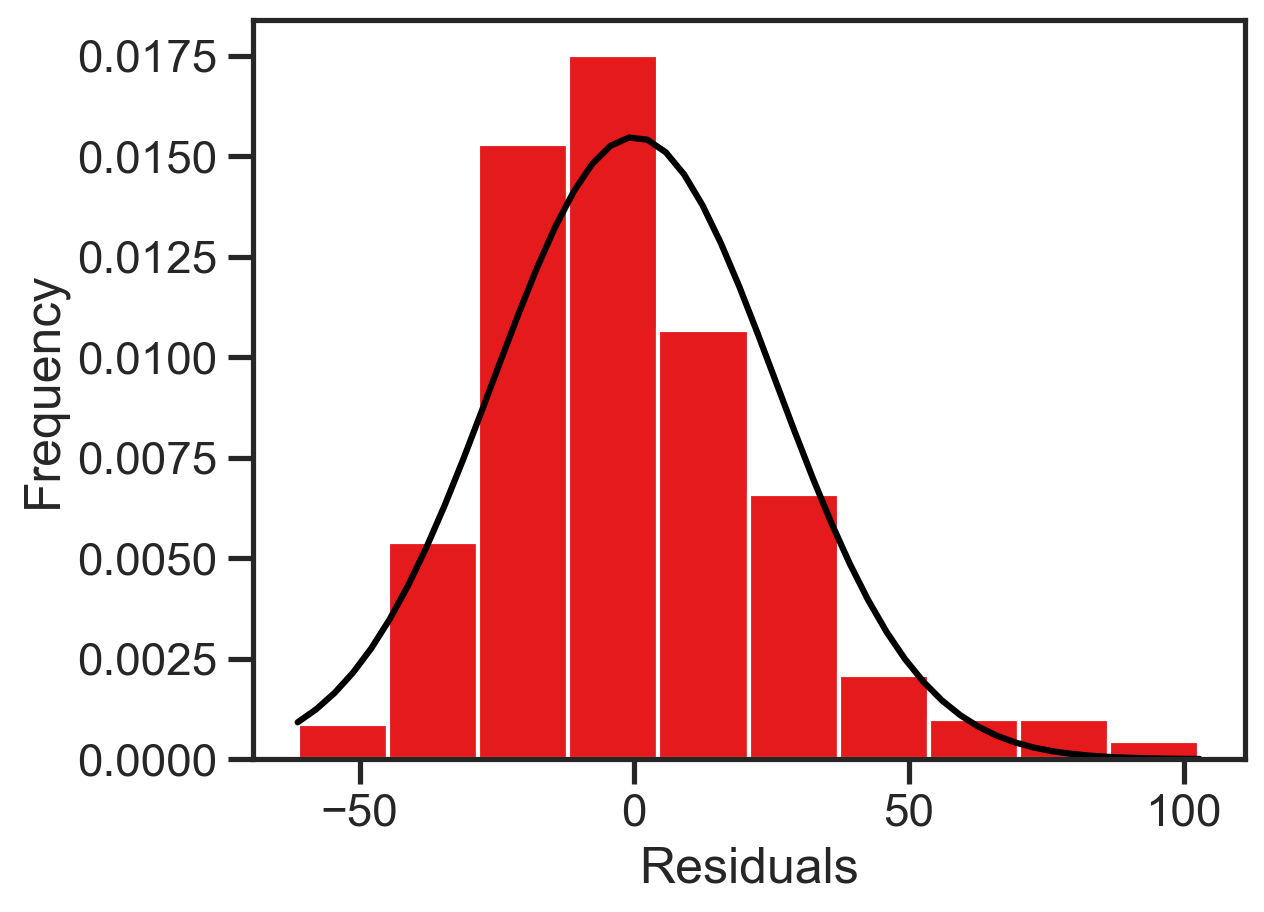

In [70]:
plt.hist(results.resid, density=True)
norm_params = scipy.stats.norm.fit(results.resid)
norm_dist = scipy.stats.norm(*norm_params)
x_range = np.linspace(results.resid.min(), results.resid.max())
plt.plot(x_range, norm_dist.pdf(x_range), color='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

_, pvalue, _, _ = sms.jarque_bera(results.resid)
print("Jarque Bera test if residuals are normally distributed? P-value = {:.2g}".format(pvalue))

_, pvalue = sms.omni_normtest(results.resid)
print("Omnibus test if residuals are normally distributed? P-value = {:.2g}".format(pvalue))

# GLM

With the normal distribution we assume that our `y` values are continous and that they can be negative -- both assumptions are unlikely to number of total points won.

To modify this assumption we can use a different distribution -- a [generalized linear models](http://www.statsmodels.org/stable/glm.html) (GLM).
This can be easily down with the `Statsmodels` package.

For example, since our `y` values are positive integers, it might be better to use the **Poisson distribution**.

In [71]:
X_ = sm.add_constant(X) # for intercept
results_poi = sm.GLM(Y, X_, family=sm.families.Poisson()).fit()
results_poi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  553
Model:                            GLM   Df Residuals:                      551
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3758.9
Date:                Thu, 09 Nov 2023   Deviance:                       4076.5
Time:                        08:36:27   Pearson chi2:                 4.28e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8218
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2136      0.009    482.696      0.000       4.196       4.231
x1             0.0396      0.001     31.517      0.000       0.037       0.042
==============================================================================
"""

The coefficients are on a different scale because when using the Poisson distribution we assumed that $\log(y) = ax + b$ rather than $y=ax+b$; here the $\log$ function is the *link function*.

The model parameters can be interpreted as follows:
- $e^b$ is the estimate for points won if 0 points were aced, $e^b = \widehat{y}(x=0)$, and
- $e^a$ is the estimate for the multiplicative increase in points won for every additional ace, $e^a = \frac{\widehat{y}(x+1)}{\widehat{y}(x)}$.



Normal:
  additive effect of aces=3.561
  without aces=65.303
Poisson:
  multiplicative effect of aces=1.040
  without aces=67.598


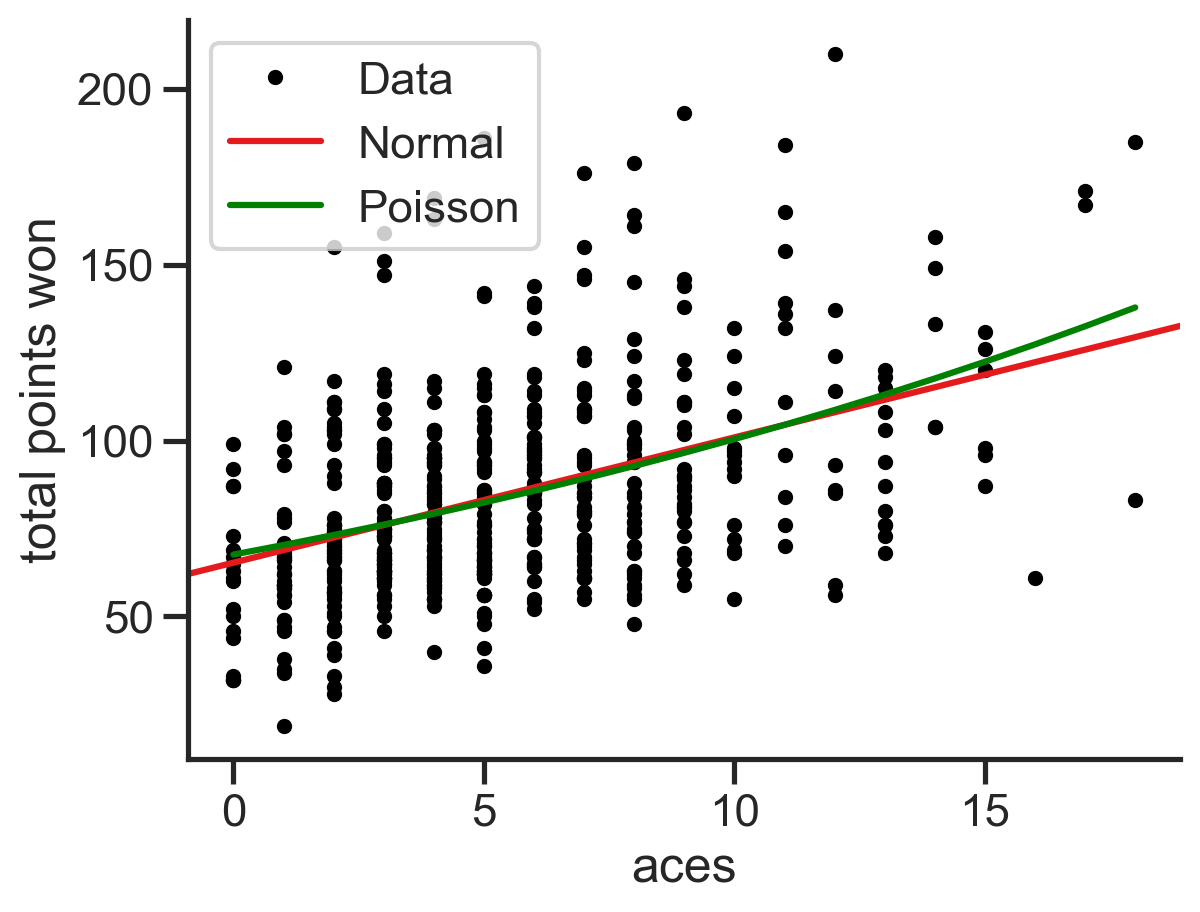

In [82]:
fig, ax = plt.subplots()
ax.plot(X, Y, '.k', label='Data')

# plot and print normal model
sm.graphics.abline_plot(model_results=results, ax=ax, label='Normal')
b, a = results.params
print("Normal:\n  additive effect of aces={:.3f}\n  without aces={:.3f}".format(
    a, b))

# plot and print poisson model
Yhat = results_poi.predict(X_)
idx = X.argsort()
ax.plot(X[idx], Yhat[idx], 'g-', label='Poisson')
b_poi, a_poi = results_poi.params
print("Poisson:\n  multiplicative effect of aces={:.3f}\n  without aces={:.3f}".format(
    np.exp(a_poi), np.exp(b_poi)))

ax.set_xlabel('aces')
ax.set_ylabel('total points won')
ax.legend(loc='upper left')
sns.despine()

We can do model selection using [Aikake Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion), or AIC:
$$
AIC = 2k - 2logL
$$
where $k$ is the number of parameters of the model and $L$ is the model likelihood.

Lower AIC is better.

In [83]:
print("AIC:")
print("  Normal:  {:.0f}".format(results.aic))
print("  Poisson: {:.0f}".format(results_poi.aic))

AIC:
  Normal:  5167
  Poisson: 7522


So the normal model seems like a better fit to the data, despite making less sense in terms of our `y` values being positive integers.

There are many more twists to add, such as regularization, outlier detection, and linking functions - we'll do the latter in the next session when we deal with the classical classification method, *logistic regression*.

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.
- Allen B. Downey, 2014. [Think Stats: Probability and Statistics for Programmers.](http://www.greenteapress.com/thinkstats2/index.html) (Available for free online).
- Cyrille Rossant, 2014. [IPython Interactive Computing and Visualization Cookbook](https://ipython-books.github.io/cookbook/) (the Tennis data is borrowed from there).
- Illustrate distributions using the [Seeing Theory](http://students.brown.edu/seeing-theory/probability-distributions/index.html#section2) webpage.
- Explore how regression is affected by outliers using the [Seeing Theory](http://students.brown.edu/seeing-theory/regression-analysis/index.html#section1) webpage.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)